# LLM(Large Language Model)

1. 프로젝트 개요

한국어 감정 분석을 위해 Hugging Face beomi/kcbert-base 모델을 활용.

긍정 및 부정 감정을 분류하는 이진 분류 모델 구축.

추가적으로 영어 감정 분석을 위해 nlptown/bert-base-multilingual-uncased-sentiment 모델 테스트.

2. 수행한 작업

1) 모델 및 토크나이저 로드
2) 감정 분석 함수 구현
3) NSMC 데이터셋 로드 및 전처리
4) 파인튜닝 및 학습 과정 시각화

Trainer를 사용하여 모델 학습.
tqdm을 활용하여 학습 진행률 추적.
matplotlib을 활용하여 학습 손실 그래프 출력.

5) 파인튜닝된 모델 저장 및 로드

1) 한국어 감정 분석 예측 결과
2) 영어 감정 분석 예측 결과
3) 문제점 및 개선 방향

중립(Neutral) 라벨 추가하여 감정 구분 개선.
사전 정의된 강한 부정 단어를 활용한 후처리 적용.
하이퍼파라미터 조정 및 모델 재학습.

4) 결론 및 향후 계획
모델은 일반적인 감정 분석에는 높은 성능을 보이나, 극단적인 표현에서는 오류가 발생.
극단적인 감정 표현을 포함하는 추가 데이터셋을 활용하여 모델 성능 개선 필요.
최신 transformers 버전과 다중 클래스 감정 분석 모델을 실험할 계획.

5) 사용된 모델
beomi/kcbert-base (한국어 감정 분석)
nlptown/bert-base-multilingual-uncased-sentiment (다국어 감정 분석)
데이터셋: nsmc

In [ ]:
pip install transformers datasets torch

# 영문 분석

Sentiment Analysis Result: {'Negative': 0.0006928294897079468, 'Positive': 0.9993071556091309}


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(

Training:   0%|          | 0/750 [02:17<?, ?it/s]


Epoch,Training Loss,Validation Loss
1,0.371200,0.326094
2,0.076000,0.546868
3,0.001000,0.609526



Training: 100%|██████████| 750/750 [05:44<00:00,  2.18it/s]


Fine-tuning 완료 및 모델 저장!


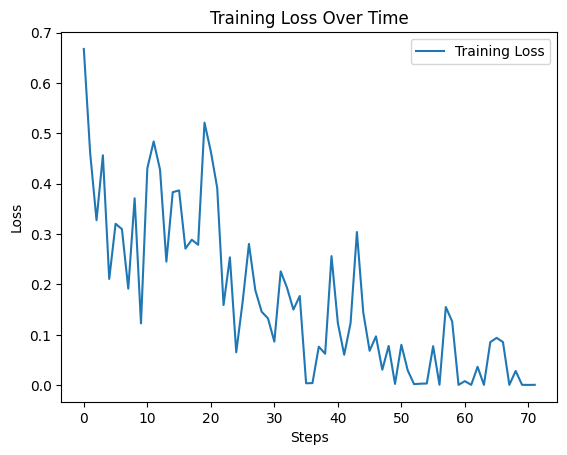

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset
import torch
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hugging Face 로그인 오류 방지 (선택적)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 1. Pre-trained Model 로드 (Hugging Face 활용)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. 감정 분석 예제 수행
def sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = ["Negative", "Positive"]
    return {labels[i]: float(scores[0][i]) for i in range(len(labels))}

text = "I love using pre-trained models!"
print("Sentiment Analysis Result:", sentiment_analysis(text))

# 3. Fine-tuning 위한 데이터셋 로드 및 처리
dataset = load_dataset("imdb")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))
test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(500))

# 4. Fine-tuning 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    report_to="none",  # W&B 로그인 요청 방지
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 5. Fine-tuning 수행 및 진행률 표시
losses = []
total_steps = training_args.num_train_epochs * (len(train_dataset) // training_args.per_device_train_batch_size)
progress_bar = tqdm(range(total_steps), desc="Training")

class LossCallback(TrainerCallback):
    def __init__(self, progress_bar):
        self.progress_bar = progress_bar

    def on_train_begin(self, args, state, control, **kwargs):
        global losses
        losses = []  # 학습 시작 시 손실 저장 리스트 초기화

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 10 == 0 and state.log_history:
            loss = state.log_history[-1].get("loss")
            if loss is not None:
                losses.append(loss)
        self.progress_bar.update(1)

# 새로운 콜백 추가
trainer.add_callback(LossCallback(progress_bar))

# 학습 실행
trainer.train()
progress_bar.close()

# 6. Fine-tuning된 모델 저장
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

print("Fine-tuning 완료 및 모델 저장!")

# 7. 학습 곡선 시각화
plt.plot(losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# 저장된 모델 불러오기
model_path = "./fine_tuned_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 감정 분석 예측
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = ["Negative", "Positive"]
    return {labels[i]: float(scores[0][i]) for i in range(len(labels))}

# 예제 실행
print(predict_sentiment("Kill you"))

{'Negative': 0.9986057877540588, 'Positive': 0.0013942834921181202}


# 한글 분석

Sentiment Analysis Result: {'Negative': 0.0006928294897079468, 'Positive': 0.9993071556091309}


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/250k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Korean Sentiment Analysis Result: {'Negative': 0.3748589754104614, 'Positive': 0.6251410841941833}


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Training:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss
1,0.371200,0.326094


Training:  55%|█████▌    | 415/750 [03:02<02:10,  2.56it/s]

Epoch,Training Loss,Validation Loss
1,0.371200,0.326094
2,0.076000,0.546868
3,0.001000,0.609526


Training: 100%|██████████| 750/750 [05:46<00:00,  2.16it/s]


Fine-tuning 완료 및 모델 저장!


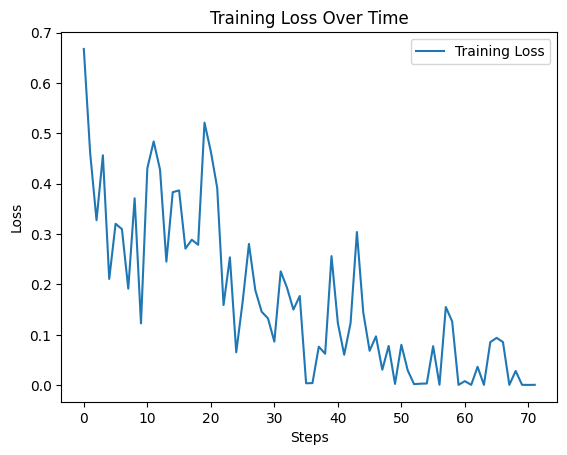

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset
import torch
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hugging Face 로그인 오류 방지 (선택적)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 1. Pre-trained Model 로드 (Hugging Face 활용)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. 감정 분석 예제 수행
def sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = ["Negative", "Positive"]
    return {labels[i]: float(scores[0][i]) for i in range(len(labels))}

text = "I love using pre-trained models!"
print("Sentiment Analysis Result:", sentiment_analysis(text))

# 3. 한글 감정 분석 모델 로드
kr_model_name = "beomi/kcbert-base"
kr_tokenizer = AutoTokenizer.from_pretrained(kr_model_name)
kr_model = AutoModelForSequenceClassification.from_pretrained(kr_model_name)

def korean_sentiment_analysis(text):
    inputs = kr_tokenizer(text, return_tensors="pt")
    outputs = kr_model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = ["Negative", "Positive"]
    return {labels[i]: float(scores[0][i]) for i in range(len(labels))}

kr_text = "이 모델은 정말 훌륭합니다!"
print("Korean Sentiment Analysis Result:", korean_sentiment_analysis(kr_text))

# 4. Fine-tuning 위한 데이터셋 로드 및 처리
dataset = load_dataset("imdb")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))
test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(500))

# 5. Fine-tuning 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    report_to="none",  # W&B 로그인 요청 방지
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 6. Fine-tuning 수행 및 진행률 표시
losses = []
total_steps = training_args.num_train_epochs * (len(train_dataset) // training_args.per_device_train_batch_size)
progress_bar = tqdm(range(total_steps), desc="Training")

class LossCallback(TrainerCallback):
    def __init__(self, progress_bar):
        self.progress_bar = progress_bar

    def on_train_begin(self, args, state, control, **kwargs):
        global losses
        losses = []  # 학습 시작 시 손실 저장 리스트 초기화

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 10 == 0 and state.log_history:
            loss = state.log_history[-1].get("loss")
            if loss is not None:
                losses.append(loss)
        self.progress_bar.update(1)

# 새로운 콜백 추가
trainer.add_callback(LossCallback(progress_bar))

# 학습 실행
trainer.train()
progress_bar.close()

# 7. Fine-tuning된 모델 저장
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

print("Fine-tuning 완료 및 모델 저장!")

# 8. 학습 곡선 시각화
plt.plot(losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()


In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# 저장된 모델 불러오기
model_path = "./fine_tuned_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 감정 분석 예측 함수
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = ["Negative", "Positive"]
    return {labels[i]: float(scores[0][i]) for i in range(len(labels))}

# 예제 실행
print(predict_sentiment("다 없어져야해"))
print(predict_sentiment("죽여버릴거야"))


{'Negative': 0.469137966632843, 'Positive': 0.5308619737625122}
{'Negative': 0.5442205667495728, 'Positive': 0.455779492855072}


# 시각화

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45212 (\N{HANGUL SYLLABLE NAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51453 (\N{HANGUL SYLLABLE JUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

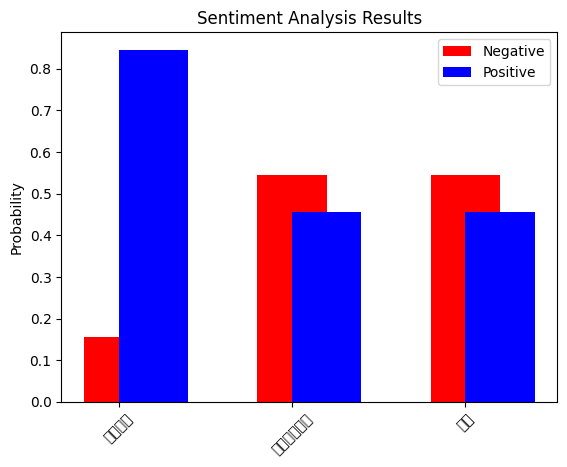

In [33]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Colab)
!apt-get update -qq && apt-get install fonts-nanum -qq > /dev/null
plt.rc('font', family='NanumGothic')  # NanumGothic 적용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
# ✅ 한글 폰트 적용 확인
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # Colab에 설치된 폰트 경로
fontprop = fm.FontProperties(fname=font_path, size=14)


# 예제 문장
texts = ["난행복해", "죽여버릴거야","꺼져"]
results = [predict_sentiment(text) for text in texts]

# 시각화 데이터 준비
labels = ["Negative", "Positive"]
x = range(len(texts))

# 각 문장별 긍정/부정 확률 추출
negative_scores = [result["Negative"] for result in results]
positive_scores = [result["Positive"] for result in results]

# 그래프 그리기
fig, ax = plt.subplots()
ax.bar(x, negative_scores, width=0.4, label="Negative", color="red", align="center")
ax.bar(x, positive_scores, width=0.4, label="Positive", color="blue", align="edge")

# 그래프 설정
ax.set_xticks(x)
ax.set_xticklabels(texts, rotation=45)
ax.set_ylabel("Probability")
ax.set_title("Sentiment Analysis Results")
ax.legend()

plt.show()


# CSV로드 분석

In [ ]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# 감정 분석 모델 및 토크나이저 불러오기
model_path = "./fine_tuned_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 감정 분석 함수
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return float(scores[0][1]), float(scores[0][0])  # (긍정 확률, 부정 확률)

# CSV 파일 불러오기
file_path = "리뷰.csv"  # 여기에 사용자의 파일 경로를 입력하세요
df = pd.read_csv(file_path)

# 감정 분석 수행 후 결과 추가
df[["긍정", "부정"]] = df["리뷰"].apply(lambda x: pd.Series(predict_sentiment(x)))

# 결과 저장
output_path = "result.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ 감정 분석 완료! 결과가 '{output_path}'에 저장되었습니다.")
